In [1]:
import os
import h3 as h3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from pyhive import presto
from keplergl import KeplerGl
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [3]:
notebook_path = os.getcwd()
print(notebook_path)

/Users/rapido/code-repository/pricing/affluence/Set-actual-pickup-distance


In [4]:
raw_order_logs_snapshot = pd.read_csv('/Users/rapido/local-datasets/affluence/raw/raw_order_logs_snapshot.csv')
raw_47_hex = pd.read_csv('/Users/rapido/local-datasets/affluence/processed/47_hex.csv')

In [5]:
print(raw_order_logs_snapshot.shape)
print(raw_47_hex.shape)

(541556, 9)
(47, 18)


In [6]:
df_order_logs_snapshot = raw_order_logs_snapshot.copy(deep=True)
print(df_order_logs_snapshot.shape)
df_order_logs_snapshot.head(2)

(541556, 9)


,yyyymmdd,city,pickup_cluster,pickup_hex_8,drop_cluster,drop_hex_8,estimate_id,order_id,geo_distance
0,20230715,Bangalore,Electronic City Phase 2,8861892629fffff,St Johns Signal,88618925c7fffff,64b2078690975ad3d453be6a,64b1ff87a085e856fc8e2d65,0.015819
1,20230715,Bangalore,Thanisandra,8861892cadfffff,Horamavu,8861892ddbfffff,64b1ff372cd7e3ed7bd7c477,64b1ff3a2c4d8e74ca7d977c,0.041362


In [7]:
df_47_hex = raw_47_hex.copy(deep=True)
print(df_47_hex.shape)
df_47_hex.head(2)

(47, 18)


,city,pickup_cluster,pickup_hex_8,usecase_tag,fe_cus_count,fe_count,requested_orders,net_orders,high_income_%,high_income_thrshld,affluence_hi_tag,link_ps,link_nps,auto_ps,auto_nps,fe_bucket,flag_2,flag_tag
0,Bangalore,Kurudusonnehalli,8861892f5bfffff,leisure,953,3737,688,279,32.0,32.0,Less,133,205,159,308,3500+,High fe,Less ps
1,Bangalore,Kurudusonnehalli,8861892f51fffff,Unknown,1280,4453,899,349,32.0,32.0,Less,184,274,193,406,3500+,High fe,Less ps


## Analysis

In [8]:
df_order_logs_snapshot

,yyyymmdd,city,pickup_cluster,pickup_hex_8,drop_cluster,drop_hex_8,estimate_id,order_id,geo_distance
0,20230715,Bangalore,Electronic City Phase 2,8861892629fffff,St Johns Signal,88618925c7fffff,64b2078690975ad3d453be6a,64b1ff87a085e856fc8e2d65,0.015819
1,20230715,Bangalore,Thanisandra,8861892cadfffff,Horamavu,8861892ddbfffff,64b1ff372cd7e3ed7bd7c477,64b1ff3a2c4d8e74ca7d977c,0.041362
2,20230715,Bangalore,Madiwala,88618925c1fffff,Arekere Extension,8861892417fffff,64b202496affce9b6469ed24,64b20262a085e856fc8e3509,0.003200
3,20230713,Bangalore,Kengeri,8860145a8dfffff,Nagarbhavi,886014585bfffff,64af41bebb105b3f19b59fa4,64af3d2155ddad19565b3882,0.004319
4,20230716,Bangalore,Hsr,8861892421fffff,HSR Sec 2,886189242dfffff,64b3f03780b8c62d6bcb78b3,64b3f04284b0c427c83a9fc8,0.026163
...,...,...,...,...,...,...,...,...,...
541551,20230710,Bangalore,BTM Second Stage,8861892437fffff,Jayanagar 4th Block,88618925d7fffff,64abc7b3477225ba05810920,64abc7d83b3a362fb49c50f1,0.008707
541552,20230710,Bangalore,Mallasandra,8860145149fffff,Mallasandra,886014514dfffff,64abce7014eed2e8b64f6159,64abce73f1c985266fbb47d3,0.016262
541553,20230710,Bangalore,Jigani,886014c90dfffff,Bommasandra Industrial Area,886189264bfffff,64abd30e8d13039d05401d9a,64abce33c5ccb3788e1f1802,0.012224
541554,20230710,Bangalore,Mallasandra,8860145149fffff,Mallasandra,886014514dfffff,64abcc474b17c43c599100b9,64abcf21220e111ae43c40ef,0.016204


In [9]:
df_order_logs_snapshot.geo_distance.describe()

count    541556.000000
mean          0.043273
std           0.515219
min           0.000000
25%           0.009739
50%           0.017832
75%           0.036580
max         357.613107
Name: geo_distance, dtype: float64

In [10]:
df_order_logs_snapshot[df_order_logs_snapshot['geo_distance'] > 2 ].count()

yyyymmdd          335
city              335
pickup_cluster    335
pickup_hex_8      335
drop_cluster      335
drop_hex_8        335
estimate_id       335
order_id          335
geo_distance      335
dtype: int64

In [11]:
(335*100/541788)

0.061832303410189964

In [12]:
df_order_logs_snapshot['geo_distance'] = np.where(df_order_logs_snapshot['geo_distance'] > 2, 2 , df_order_logs_snapshot['geo_distance'])

In [13]:
df_order_logs_snapshot.geo_distance.describe()

count    541556.000000
mean          0.040833
std           0.095085
min           0.000000
25%           0.009739
50%           0.017832
75%           0.036580
max           2.000000
Name: geo_distance, dtype: float64

<Axes: ylabel='Frequency'>

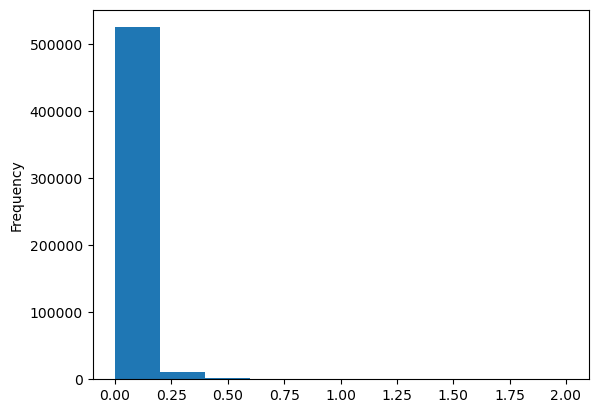

In [14]:
df_order_logs_snapshot['geo_distance'].plot(kind = 'hist')

In [17]:
df_analysis = df_order_logs_snapshot.groupby(['pickup_cluster', 'pickup_hex_8']).agg({'order_id': 'count',
                                                                 'geo_distance' : ['mean', 'max']
                                                                              })
df_analysis.columns = df_analysis.columns.droplevel(0)
df_analysis.rename(columns = {'count' : 'orders',
                              'mean' : 'avg_geo_distance',
                              'max' : 'max_geo_distance'
                             }, inplace = True)
df_analysis = df_analysis.reset_index()

In [18]:
df_analysis['avg_geo_distance'] = round(df_analysis['avg_geo_distance'], 3)
df_analysis['max_geo_distance'] = round(df_analysis['max_geo_distance'], 3)

In [19]:
df_analysis

,pickup_cluster,pickup_hex_8,orders,avg_geo_distance,max_geo_distance
0,AECS Layout Brookefield,88618920a3fffff,4017,0.030,2.000
1,Adugodi,8861892581fffff,1038,0.034,0.788
2,Adugodi,886189258bfffff,1031,0.050,2.000
3,Adugodi Traffic Station,886189258dfffff,1500,0.041,2.000
4,Agara Lake,8861892425fffff,1384,0.029,1.083
...,...,...,...,...,...
1631,Yeshwanthpur,8860145955fffff,141,0.106,1.899
1632,Yeshwanthpur,8860145957fffff,593,0.080,1.824
1633,Yeshwanthpur,8860145959fffff,234,0.041,1.404
1634,Yeshwanthpur,886014595bfffff,223,0.029,0.384


In [20]:
df_analysis[['avg_geo_distance','max_geo_distance']].describe()

,avg_geo_distance,max_geo_distance
count,1636.000000,1636.000000
mean,0.067497,0.793278
std,0.103045,0.686686
min,0.000000,0.000000
25%,0.033000,0.201500
50%,0.045000,0.580000
75%,0.066000,1.276500
max,2.000000,2.000000


In [21]:
df_47_hex.head(1)

,city,pickup_cluster,pickup_hex_8,usecase_tag,fe_cus_count,fe_count,requested_orders,net_orders,high_income_%,high_income_thrshld,affluence_hi_tag,link_ps,link_nps,auto_ps,auto_nps,fe_bucket,flag_2,flag_tag
0,Bangalore,Kurudusonnehalli,8861892f5bfffff,leisure,953,3737,688,279,32.0,32.0,Less,133,205,159,308,3500+,High fe,Less ps


In [23]:
df_merge = pd.merge(
        df_analysis,
        df_47_hex,
        how = 'left',
        left_on = ['pickup_hex_8', 'pickup_cluster'],
        right_on = ['pickup_hex_8', 'pickup_cluster']
        )   

df_merge

,pickup_cluster,pickup_hex_8,orders,avg_geo_distance,max_geo_distance,city,usecase_tag,fe_cus_count,fe_count,requested_orders,net_orders,high_income_%,high_income_thrshld,affluence_hi_tag,link_ps,link_nps,auto_ps,auto_nps,fe_bucket,flag_2,flag_tag
0,AECS Layout Brookefield,88618920a3fffff,4017,0.030,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adugodi,8861892581fffff,1038,0.034,0.788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Adugodi,886189258bfffff,1031,0.050,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adugodi Traffic Station,886189258dfffff,1500,0.041,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Agara Lake,8861892425fffff,1384,0.029,1.083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,Yeshwanthpur,8860145955fffff,141,0.106,1.899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1632,Yeshwanthpur,8860145957fffff,593,0.080,1.824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1633,Yeshwanthpur,8860145959fffff,234,0.041,1.404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1634,Yeshwanthpur,886014595bfffff,223,0.029,0.384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_merge.columns

Index(['pickup_cluster', 'pickup_hex_8', 'orders', 'avg_geo_distance',
       'max_geo_distance', 'city', 'usecase_tag', 'fe_cus_count', 'fe_count',
       'requested_orders', 'net_orders', 'high_income_%',
       'high_income_thrshld', 'affluence_hi_tag', 'link_ps', 'link_nps',
       'auto_ps', 'auto_nps', 'fe_bucket', 'flag_2', 'flag_tag'],
      dtype='object')

In [26]:
df_merge = df_merge[['pickup_cluster', 'pickup_hex_8', 'orders',
       'avg_geo_distance', 'max_geo_distance','city', 'usecase_tag', 'fe_cus_count',
       'fe_count', 'requested_orders', 'net_orders', 'high_income_%', 'affluence_hi_tag',  'flag_2']]

In [27]:
df_merge.to_csv('/Users/rapido/local-datasets/affluence/processed/set_actual_pickup_diatance.csv', index = False)

In [28]:
df_merge

,pickup_cluster,pickup_hex_8,orders,avg_geo_distance,max_geo_distance,city,usecase_tag,fe_cus_count,fe_count,requested_orders,net_orders,high_income_%,affluence_hi_tag,flag_2
0,AECS Layout Brookefield,88618920a3fffff,4017,0.030,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adugodi,8861892581fffff,1038,0.034,0.788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Adugodi,886189258bfffff,1031,0.050,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adugodi Traffic Station,886189258dfffff,1500,0.041,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Agara Lake,8861892425fffff,1384,0.029,1.083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,Yeshwanthpur,8860145955fffff,141,0.106,1.899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1632,Yeshwanthpur,8860145957fffff,593,0.080,1.824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1633,Yeshwanthpur,8860145959fffff,234,0.041,1.404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1634,Yeshwanthpur,886014595bfffff,223,0.029,0.384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_merge[['avg_geo_distance', 'max_geo_distance']].describe()

,avg_geo_distance,max_geo_distance
count,1636.000000,1636.000000
mean,0.067497,0.793278
std,0.103045,0.686686
min,0.000000,0.000000
25%,0.033000,0.201500
50%,0.045000,0.580000
75%,0.066000,1.276500
max,2.000000,2.000000


In [33]:
df_merge['distance_tag'] = np.where(df_merge['max_geo_distance'] > 0.20, 'high', 'low')
df_merge.groupby(['affluence_hi_tag','flag_2','distance_tag']).agg({'pickup_hex_8':'count'})

,,,pickup_hex_8
affluence_hi_tag,flag_2,distance_tag,
Less,High fe,high,47


In [34]:
df_merge.groupby(['distance_tag']).agg({'pickup_hex_8':'count'})

,pickup_hex_8
distance_tag,
high,1227
low,409
